# Analyzing Boston's Rideshare Data

In [1]:
# General imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from copy import copy

# Data pipeline imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Load Data Set

In [2]:
df = pd.read_excel('rideshare.xls')
df.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,Lyft,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,Lyft,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,1,28,11,2018-11-28 01:00:22,America/New_York,Haymarket Square,North Station,Lyft,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,4,30,11,2018-11-30 04:53:02,America/New_York,Haymarket Square,North Station,Lyft,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,3,29,11,2018-11-29 03:49:20,America/New_York,Haymarket Square,North Station,Lyft,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800


## EDA

In [3]:
# Get shape of the data set
df.shape

(11999, 57)

In [4]:
# Get number of null values
df.isnull().sum()

id                               0
timestamp                        0
hour                             0
day                              0
month                            0
datetime                         0
timezone                         0
source                           0
destination                      0
cab_type                         0
product_id                       0
name                             0
price                          931
distance                         0
surge_multiplier                 0
latitude                         0
longitude                        0
temperature                      0
apparentTemperature              0
short_summary                    0
long_summary                     0
precipIntensity                  0
precipProbability                0
humidity                         0
windSpeed                        0
windGust                         0
windGustTime                     0
visibility                       0
temperatureHigh     

In [5]:
# Number of unique values in each data set
df.nunique()

id                             11999
timestamp                      10878
hour                              24
day                               17
month                              2
datetime                        9253
timezone                           1
source                            12
destination                       12
cab_type                           2
product_id                        13
name                              13
price                            101
distance                         360
surge_multiplier                   6
latitude                          11
longitude                         12
temperature                      308
apparentTemperature              319
short_summary                      9
long_summary                      11
precipIntensity                   63
precipProbability                 29
humidity                          51
windSpeed                        291
windGust                         286
windGustTime                      25
v

# Preprocessing Pipeline

- Drop unneeded columns
- Encode categorical columns
- Impute price column:
    - <strong>Remove column</strong> = Losing potential data values but also means that we aren't guessing the price

In [6]:
# Define drop columns
drop = ['id', 'timezone', 'timestamp', 'latitude', 'longitude', 'product_id', 
        'uvIndexTime', 'short_summary', 'visibility.1', 'icon', 'datetime']

# Add all columns with Time measurements -> we only need one time measurement
for cols in df.columns:
    if "Time" in cols:
        drop.append(cols)

In [7]:
# Drop columns
df = df.drop(drop,axis=1)
df = df.dropna()

In [8]:
df_uber = df[df['cab_type'] == "Uber"]
df_lyft = df[df['cab_type'] == "Lyft"]

In [9]:
df_uber.tail()

,hour,day,month,source,destination,cab_type,name,price,distance,surge_multiplier,...,windBearing,cloudCover,uvIndex,ozone,moonPhase,precipIntensityMax,temperatureMin,temperatureMax,apparentTemperatureMin,apparentTemperatureMax
11981,2,29,11,West End,Fenway,Uber,Black SUV,29.5,2.84,1.0,...,305,0.75,0,348.9,0.72,0.0000,33.60,42.70,30.08,36.77
11983,20,28,11,West End,Fenway,Uber,UberXL,17.5,2.84,1.0,...,295,1.00,0,355.0,0.72,0.0000,33.70,42.57,29.94,36.55
11984,6,2,12,West End,Fenway,Uber,UberX,11.5,2.84,1.0,...,135,1.00,0,269.6,0.86,0.0956,36.10,50.37,35.88,49.70
11997,18,13,12,Back Bay,North End,Uber,UberXL,14.0,2.33,1.0,...,51,0.61,1,330.9,0.21,0.0001,17.85,33.78,13.73,33.11
11998,14,17,12,Back Bay,North End,Uber,WAV,9.0,2.33,1.0,...,328,1.00,1,326.0,0.33,0.0185,34.07,41.39,28.17,35.93


In [10]:
# One hot encoding in respective DataFrames

# Encode Uber and Lyftcar types
df_uber = pd.get_dummies(df_uber, columns = ['name'])
df_lyft = pd.get_dummies(df_lyft, columns = ['name'])

### Check For Changes

In [11]:
df_lyft.columns

Index(['hour', 'day', 'month', 'source', 'destination', 'cab_type', 'price',
       'distance', 'surge_multiplier', 'temperature', 'apparentTemperature',
       'long_summary', 'precipIntensity', 'precipProbability', 'humidity',
       'windSpeed', 'windGust', 'visibility', 'temperatureHigh',
       'temperatureLow', 'apparentTemperatureHigh', 'apparentTemperatureLow',
       'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex', 'ozone',
       'moonPhase', 'precipIntensityMax', 'temperatureMin', 'temperatureMax',
       'apparentTemperatureMin', 'apparentTemperatureMax', 'name_Lux',
       'name_Lux Black', 'name_Lux Black XL', 'name_Lyft', 'name_Lyft XL',
       'name_Shared'],
      dtype='object')

In [12]:
df_uber.columns

Index(['hour', 'day', 'month', 'source', 'destination', 'cab_type', 'price',
       'distance', 'surge_multiplier', 'temperature', 'apparentTemperature',
       'long_summary', 'precipIntensity', 'precipProbability', 'humidity',
       'windSpeed', 'windGust', 'visibility', 'temperatureHigh',
       'temperatureLow', 'apparentTemperatureHigh', 'apparentTemperatureLow',
       'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex', 'ozone',
       'moonPhase', 'precipIntensityMax', 'temperatureMin', 'temperatureMax',
       'apparentTemperatureMin', 'apparentTemperatureMax', 'name_Black',
       'name_Black SUV', 'name_UberPool', 'name_UberX', 'name_UberXL',
       'name_WAV'],
      dtype='object')

# Data Visualization

### Distribution of Prices Across Rideshare Companies

/Users/srihariraman/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


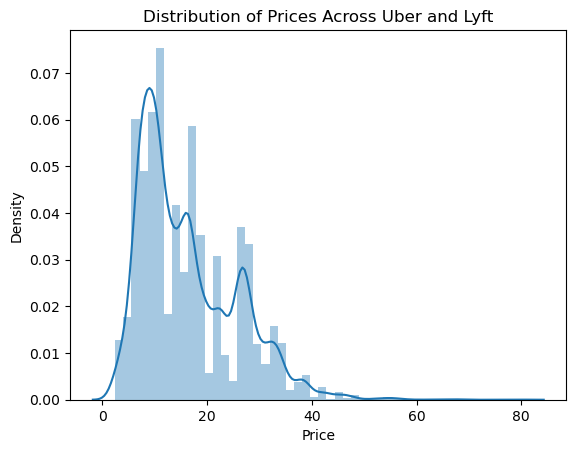

In [13]:
# Plot distribution plot
sns.distplot(df['price'], kde=True)
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Distribution of Prices Across Uber and Lyft');

/Users/srihariraman/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/srihariraman/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


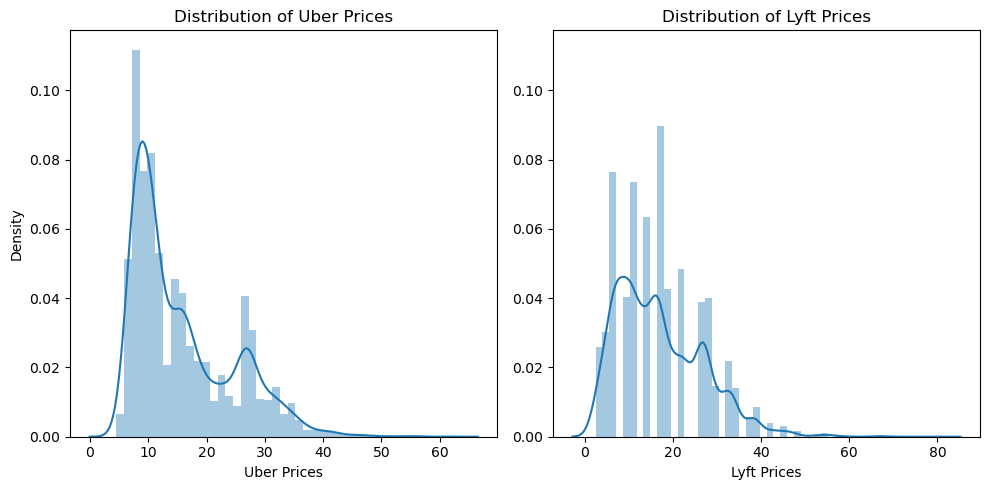

In [14]:
# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the distribution for Uber
sns.distplot(df_uber['price'], ax=axes[0])

# Plot the distribution for Lyft
sns.distplot(df_lyft['price'], ax=axes[1])

# Set the same y-value limit for both plots
max_y = max(max(axes[0].get_ylim()), max(axes[1].get_ylim()))
axes[0].set_ylim(0, max_y)
axes[1].set_ylim(0, max_y)

# Set titles and labels
axes[0].set_title('Distribution of Uber Prices')
axes[0].set_xlabel('Uber Prices')
axes[0].set_ylabel('Density')

axes[1].set_title('Distribution of Lyft Prices')
axes[1].set_xlabel('Lyft Prices')
axes[1].set_ylabel('')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

### Distribution of Prices Against Major Weather Patterns

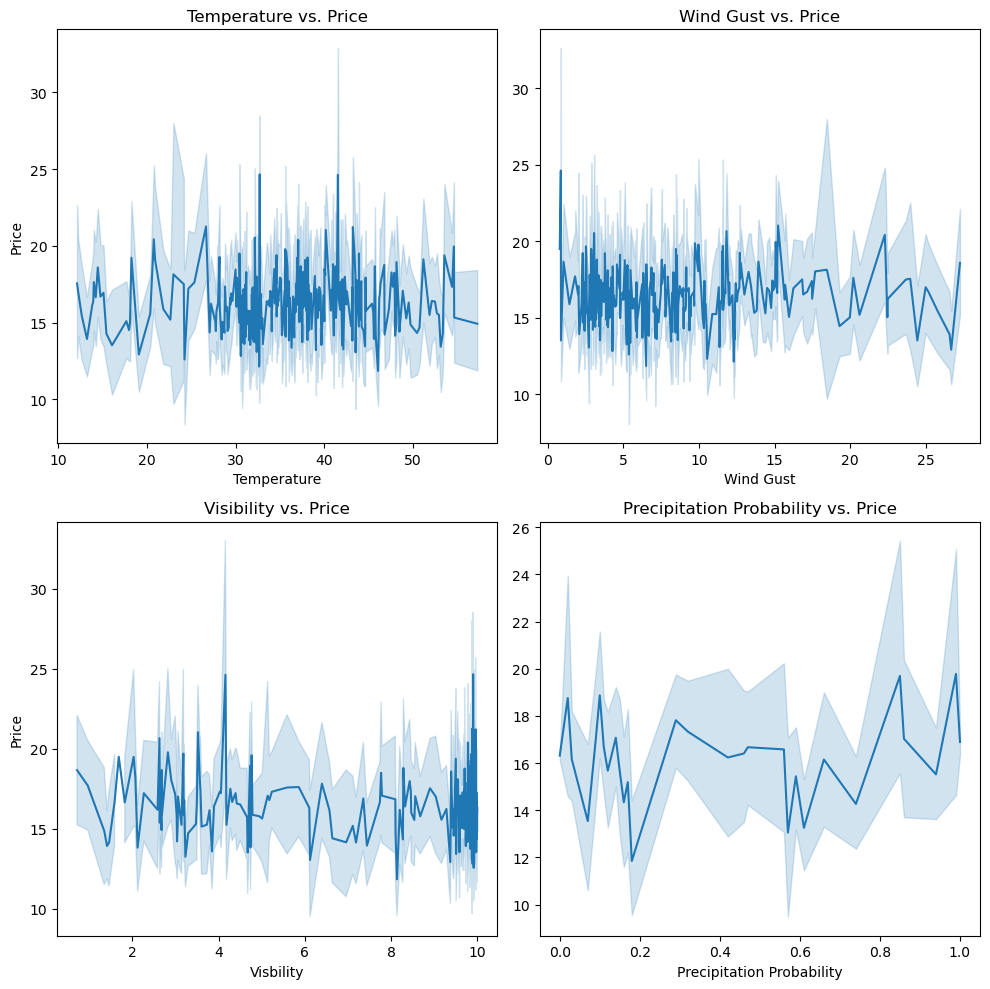

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Set up lineplots for each variable
sns.lineplot(data=df, x='apparentTemperature', y='price', ax=axes[0, 0])
sns.lineplot(data=df, x='windGust', y='price', ax=axes[0, 1]) 
sns.lineplot(data=df, x='visibility', y='price', ax=axes[1, 0]) 
sns.lineplot(data=df, x='precipProbability', y='price', ax=axes[1, 1])  

# Set titles and labels
axes[0, 0].set_title('Temperature vs. Price')
axes[0, 0].set_xlabel('Temperature')
axes[0, 0].set_ylabel('Price')

axes[0, 1].set_title('Wind Gust vs. Price')
axes[0, 1].set_xlabel('Wind Gust')
axes[0, 1].set_ylabel('')

axes[1, 0].set_title('Visibility vs. Price')
axes[1, 0].set_xlabel('Visbility')
axes[1, 0].set_ylabel('Price')

axes[1, 1].set_title('Precipitation Probability vs. Price')
axes[1, 1].set_xlabel('Precipitation Probability')
axes[1, 1].set_ylabel('')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

### Distribution of Prices Against Distance

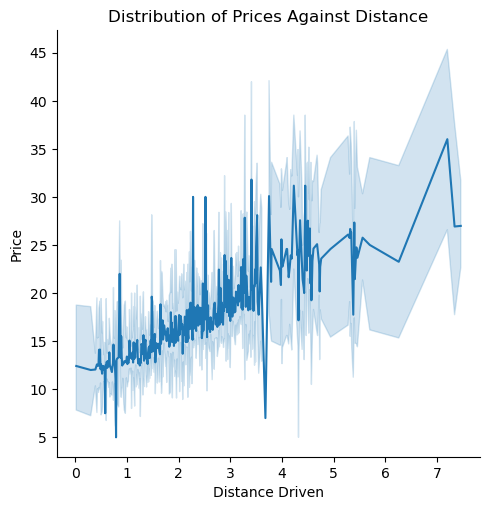

In [16]:
# Create relation plot
sns.relplot(data=df, x='distance', y='price', kind="line")
plt.title('Distribution of Prices Against Distance')
plt.xlabel('Distance Driven')
plt.ylabel('Price');

### Distribution of Price Surges Against Time of Day

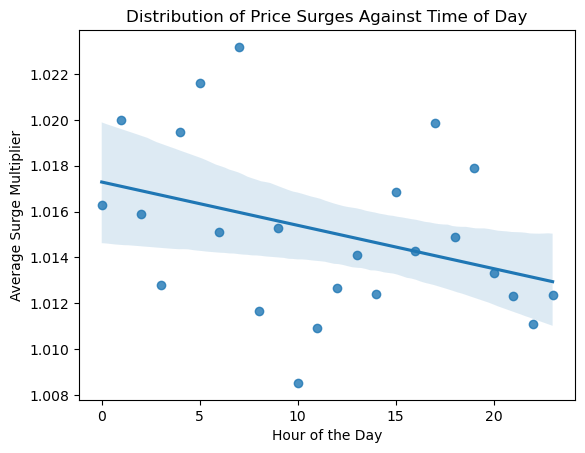

In [17]:
# Group DF by Hour of Time
df_grouped = pd.DataFrame(df.groupby(['hour']).mean())

# Plot regression plot to see if there is a linear relationship
sns.regplot(x=df_grouped.index, y=df_grouped['surge_multiplier'])
plt.xlabel('Hour of the Day')
plt.ylabel('Average Surge Multiplier')
plt.title('Distribution of Price Surges Against Time of Day');

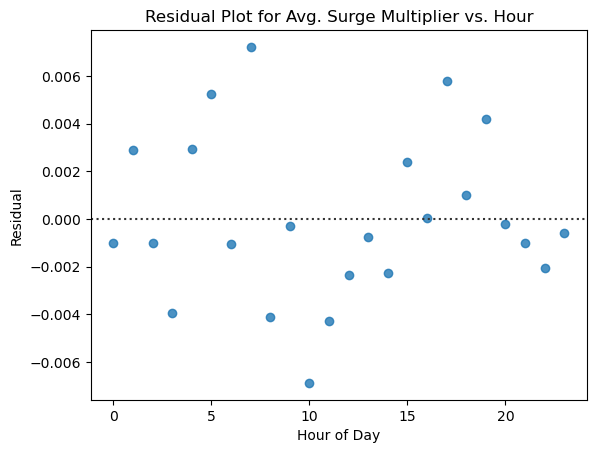

In [18]:
# Plot residual plot to see if linear relationship is a good fit
sns.residplot(x=df_grouped.index, y=df_grouped['surge_multiplier'])
plt.xlabel('Hour of Day')
plt.ylabel('Residual')
plt.title('Residual Plot for Avg. Surge Multiplier vs. Hour');

<strong>Analysis: </strong>There is no apparent relationship in the distribution of residuals for the linear plot described above. Hence, the linear relationship is somewhat representative of the relationship between the average surge multiplier and the hour of day. However, there is no obvious indication of a negative relationship between the two variables as the regression plot clearly doesn't represent the data shown.

# ML Implementation

## Overview

<strong>Executive Summary:</strong> I'd like to take the various inputs using various Regression models to try and predict the price of an Uber and Lyft. Using the same variables, I'd like to create seperate regression models for these two rideshare companies to analyze how their pricing model works. Then, post-training the regression models for each of the individual rideshare companies, I'd like to test how the model predicts prices for the same data but for the other rideshare company. With reasonable accuracy, if both models predict vastly different prices for the respective rideshare companies, we know that the specific rideshare company with higher-than-predicted pricing is pricing unfairly.

### Regression Model for Uber 

In [19]:
# Drop cab type + other columns to avoid weightage bias in both DataFrames
df_uber = df_uber.drop(['cab_type', 'destination', 'source'], axis=1)

In [21]:
# Extract features and target variables for both data frames
x_feat_uber = [col for col in df_uber.columns if col not in ['price', 'long_summary']]
y_feat_uber = 'price'

x_uber = df_uber.loc[:, x_feat_uber].values
y_uber = df_uber.loc[:, y_feat_uber].values

In [22]:
# Split datasets into test and train values
XU_train, XU_test, yU_train, yU_test = train_test_split(x_uber, y_uber, test_size=0.33, random_state=42)

In [36]:
# Create the regression model and fit the training data in it
reg_uber = LinearRegression().fit(XU_train, yU_train)

In [49]:
# Predict on the test data
pred = reg_uber.predict(XU_test)

In [63]:
uber_reg = pd.DataFrame(list(zip(XU_test.ravel(), yU_test.ravel(), pred.ravel())),
               columns =['X', 'Actual Y', 'Predicted Y'])

<AxesSubplot:xlabel='X', ylabel='Predicted Y'>

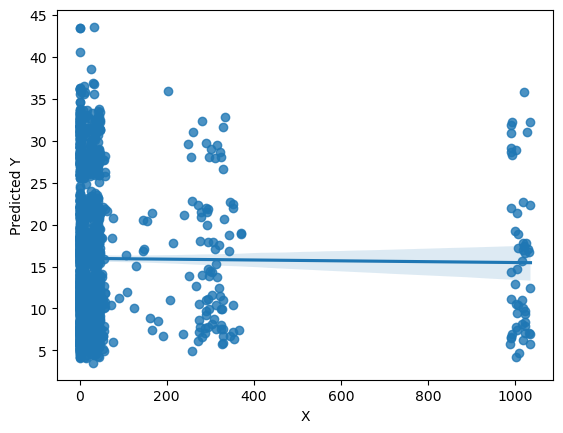

In [64]:
sns.regplot(data=uber_reg, x='X', y='Predicted Y')

### Regression Model for Lyft

In [25]:
df_lyft = df_lyft.drop(['cab_type', 'destination'], axis=1)
x_feat_lyft = [col for col in df_lyft.columns if col != 'price']
y_feat_lyft = 'price'

x_lyft = df_lyft.loc[:, x_feat_lyft].values
y_lyft = df_lyft.loc[:, y_feat_lyft].values

In [26]:
x_feat_lyft = [col for col in df_lyft.columns if col != 'price']
y_feat_lyft = 'price'

In [27]:
XL_train, XL_test, yL_train, yL_test = train_test_split(x_lyft, y_lyft, test_size=0.33, random_state=42)